In [58]:
import numpy as np
import deepxde as dde
import matplotlib.pyplot as plt

In [17]:
eps_r = 1.0
mu_r = 1.0

In [346]:
period_t = np.sqrt(2)
Tmax = period_t # Total time
xmin = 0
xmax = 1
ymin = 0
ymax = 1
geom = dde.geometry.Rectangle([xmin, ymin], [xmax, ymax])
 # Define the spatial domain of the problem
timedomain = dde.geometry.TimeDomain(0, Tmax) # Define the temporal domain of the problem
geomtime = dde.geometry.GeometryXTime(geom, timedomain)



In [347]:
def cavity_analytical(x, y, t, w):
    Hx = -(np.pi / w) * np.sin(np.pi * x) * np.cos(np.pi * y) * np.sin(w * t) 
    Hy = (np.pi / w) * np.cos(np.pi * x) * np.sin(np.pi * y) * np.sin(w * t) 
    Ez = np.sin(np.pi * x) * np.sin(np.pi * y) * np.cos(w * t) 
    return Hx, Hy, Ez

def initial_cavity(var):
    x, y = var[:, 0], var[:, 1]
    Hx = np.zeros_like(x)
    Hy = np.zeros_like(x)
    Ez = np.sin(np.pi * x) * np.sin(np.pi * y)

    return np.array([Hx, Hy, Ez])

def PEC_condition(X, on_boundary):
    return [0, 0, 0]

In [348]:
def pde(X, Y): # Define the system of PDEs for Maxwell 2D
    # t = X[:, 0]
    # x = var[:, 1]
    # y = var[:, 2]
    # Hx = out[:, 0]
    # Hy = out[:, 1]
    # Ez = out[:, 2]
    dEz_t = dde.grad.jacobian(Y, X, i=2, j=2)
    dEz_x = dde.grad.jacobian(Y, X, i=2, j=0)
    dEz_y = dde.grad.jacobian(Y, X, i=2, j=1)
    dHx_t = dde.grad.jacobian(Y, X, i=0, j=2)
    dHx_y = dde.grad.jacobian(Y, X, i=0, j=1)
    dHy_t = dde.grad.jacobian(Y, X, i=1, j=2)
    dHy_x = dde.grad.jacobian(Y, X, i=1, j=0)
    
    res_Hx = dHx_t + 1 / mu_r * dEz_y
    res_Hy = dHy_t - 1 / mu_r * dEz_x
    res_Ez = dEz_t - 1 / eps_r * (dHy_x - dHx_y)
    return [res_Hx, res_Hy, res_Ez]

In [349]:
def boundary_cavity(X, on_boundary):
    x = X[:, 0]
    y = X[:, 1]
    return np.isclose(x,xmin) or np.isclose(x,xmax) or np.isclose(y,ymin) or np.isclose(y,ymax)

def initial_condition(X, on_initial):
    t = X[:, 2]
    return np.isclose(t, 0)


In [350]:
bc = dde.icbc.DirichletBC(geomtime, lambda x: 0, lambda _, on_boundary:on_boundary, component=2) # Define PEC BC (Ez=0)

ic_Hx = dde.icbc.IC(geomtime, lambda x: 0, lambda _, on_initial:on_initial, component=0) # Define initial conditions
ic_Hy = dde.icbc.IC(geomtime, lambda x: 0, lambda _, on_initial:on_initial, component=1)
ic_Ez = dde.icbc.IC(geomtime, lambda x: np.sin(np.pi * x[:, 0:1]) * np.sin(np.pi * x[:, 1:2]), lambda _, on_initial:on_initial, component=2)

In [385]:
N_domain = 2000 # Number of training samples in the domain
N_boundary = 600 # Number of training samples on the boundary
N_initial = 400 # Number of training samples for the initial condition

data = dde.data.TimePDE(geomtime, pde, [bc, ic_Hx, ic_Hy, ic_Ez], #  Define the PDE problem wit
                        num_domain=N_domain, num_boundary=N_boundary, num_initial=N_initial)

In [202]:
# loss_weights = [0, 0, 0, 0, 1, 1, 1]

In [386]:
net = dde.nn.FNN([3] + [30] *3 + [3], "tanh", "Glorot normal")

In [387]:
model = dde.Model(data, net)
model.compile("adam", lr=1e-3)

Compiling model...
'compile' took 0.000312 s



In [392]:
losshistory, train_state = model.train(iterations=15000)

Training model...

Step      Train loss                                                                Test loss                                                                 Test metric
15000     [5.97e-05, 6.41e-05, 8.40e-05, 2.44e-04, 9.03e-06, 6.79e-06, 2.82e-05]    [5.97e-05, 6.41e-05, 8.40e-05, 2.44e-04, 9.03e-06, 6.79e-06, 2.82e-05]    []  


16000     [5.30e-05, 5.57e-05, 6.87e-05, 2.17e-04, 8.23e-06, 6.72e-06, 2.33e-05]    [5.30e-05, 5.57e-05, 6.87e-05, 2.17e-04, 8.23e-06, 6.72e-06, 2.33e-05]    []  
17000     [4.87e-05, 5.08e-05, 6.16e-05, 2.03e-04, 7.89e-06, 6.50e-06, 2.27e-05]    [4.87e-05, 5.08e-05, 6.16e-05, 2.03e-04, 7.89e-06, 6.50e-06, 2.27e-05]    []  
18000     [4.42e-05, 4.66e-05, 5.60e-05, 1.88e-04, 7.33e-06, 6.26e-06, 1.87e-05]    [4.42e-05, 4.66e-05, 5.60e-05, 1.88e-04, 7.33e-06, 6.26e-06, 1.87e-05]    []  
19000     [4.12e-05, 4.32e-05, 5.51e-05, 1.80e-04, 7.51e-06, 6.41e-06, 1.90e-05]    [4.12e-05, 4.32e-05, 5.51e-05, 1.80e-04, 7.51e-06, 6.41e-06, 1.90e-05]    []  
20000     [3.81e-05, 4.01e-05, 4.72e-05, 1.68e-04, 6.89e-06, 6.03e-06, 1.55e-05]    [3.81e-05, 4.01e-05, 4.72e-05, 1.68e-04, 6.89e-06, 6.03e-06, 1.55e-05]    []  
21000     [3.57e-05, 3.74e-05, 4.39e-05, 1.60e-04, 6.68e-06, 5.91e-06, 1.45e-05]    [3.57e-05, 3.74e-05, 4.39e-05, 1.60e-04, 6.68e-06, 5.91e-06, 1.45e-05]    []  
22000     [3.38e-05, 3

In [393]:
from scipy.interpolate import griddata

t = np.linspace(0, Tmax, 100)
x = np.linspace(xmin, xmax, 256)
y = np.linspace(ymin, ymax, 256)

X, Y, T = np.meshgrid(x, y, t)

# The whole domain flattened
X_star = np.hstack((X.flatten()[:, None], Y.flatten()[:, None], T.flatten()[:, None]))

out_pred = model.predict(X_star, operator=None)

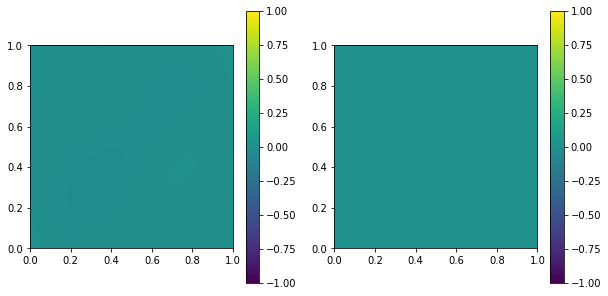

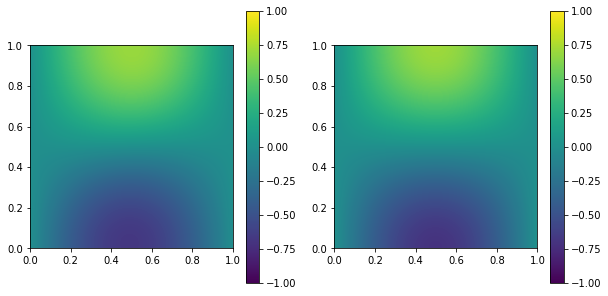

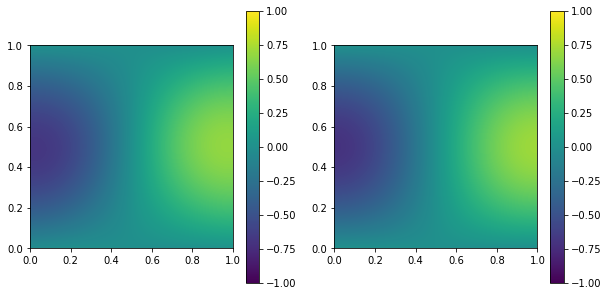

In [394]:
#unflatten the data
Hx_pred = out_pred[:, 0].reshape(X.shape)
Hy_pred = out_pred[:, 1].reshape(X.shape)
Ez_pred = out_pred[:, 2].reshape(X.shape)

# Analytical solution
w = np.pi * np.sqrt(2)
t0 = 3*period_t/4
idx_t0 = np.argmin(np.abs(t - t0))
xx, yy = np.meshgrid(x, y)
Hx_analytical, Hy_analytical, Ez_analytical = cavity_analytical(xx, yy, t0, w)

# Plot Ez field
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
p1 = ax[0].imshow(Ez_pred[:, :, idx_t0], extent=[xmin, xmax, ymin, ymax], vmin=-1, vmax=1)
p2 = ax[1].imshow(Ez_analytical, extent=[xmin, xmax, ymin, ymax], vmin=-1, vmax=1)
fig.colorbar(p1, ax=ax[0])
fig.colorbar(p2, ax=ax[1])

# Plot Hx field
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
p1 = ax[0].imshow(Hx_pred[:, :, idx_t0], extent=[xmin, xmax, ymin, ymax], vmin=-1, vmax=1)
p2 = ax[1].imshow(Hx_analytical, extent=[xmin, xmax, ymin, ymax], vmin=-1, vmax=1)
fig.colorbar(p1, ax=ax[0])
fig.colorbar(p2, ax=ax[1])

# Plot Hy field
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
p1 = ax[0].imshow(Hy_pred[:, :, idx_t0], extent=[xmin, xmax, ymin, ymax], vmin=-1, vmax=1)
p2 = ax[1].imshow(Hy_analytical, extent=[xmin, xmax, ymin, ymax], vmin=-1, vmax=1)
fig.colorbar(p1, ax=ax[0])
fig.colorbar(p2, ax=ax[1])

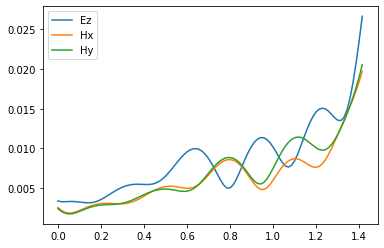

In [395]:
# Compute L2 error as a function of time for the fields
L2_error = np.zeros((len(t), 3))
for i in range(len(t)):
    Hx_analytical, Hy_analytical, Ez_analytical = cavity_analytical(xx, yy, t[i], w)
    L2_error[i, 0] = np.sqrt(np.mean((Ez_pred[:, :, i] - Ez_analytical)**2))
    L2_error[i, 1] = np.sqrt(np.mean((Hx_pred[:, :, i] - Hx_analytical)**2))
    L2_error[i, 2] = np.sqrt(np.mean((Hy_pred[:, :, i] - Hy_analytical)**2))

# Plot L2 error
plt.plot(t, L2_error[:, 0], label="Ez")
plt.plot(t, L2_error[:, 1], label="Hx")
plt.plot(t, L2_error[:, 2], label="Hy")
plt.legend()


In [345]:
Tmax

5.656854249492381

In [208]:
.shape

SyntaxError: invalid syntax (1189770672.py, line 1)

Saving loss history to /home/rgelly/Documents/MasterIM/MachineLearning/Projet/Maxwell_PINN/loss.dat ...
Saving training data to /home/rgelly/Documents/MasterIM/MachineLearning/Projet/Maxwell_PINN/train.dat ...
Saving test data to /home/rgelly/Documents/MasterIM/MachineLearning/Projet/Maxwell_PINN/test.dat ...


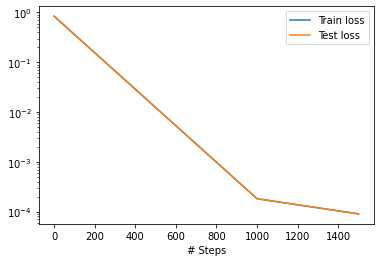

In [ ]:
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

In [ ]:
X, y_true = gen_testdata() # Load reference solution
y_pred = model.predict(X) # Predict solution from network
f = model.predict(X, operator=pde) # Compute PDE residual
print("Mean residual:", np.mean(np.absolute(f)))
print("L2 relative error:", dde.metrics.l2_relative_error(y_true, y_pred))
np.savetxt("test.dat", np.hstack((X, y_true, y_pred)))

t.shape:  (100, 1)
x.shape:  (256, 1)
Mean residual: 0.016651733
L2 relative error: 0.07965886250530299


(2,)


In [ ]:
t_array, x_array = np.reshape(X[:,1], (100, 256))[:,0], np.reshape(X[:,0], (100, 256))[0,:]
ypred_array = np.reshape(y_pred, (100, 256))
ytrue_array = np.reshape(y_true, (100, 256))

In [ ]:
ypred_array.shape

(100, 256)

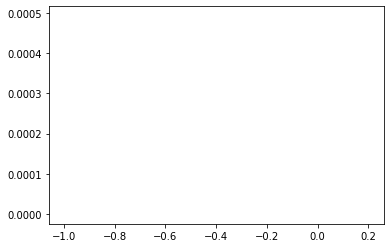

In [ ]:
# Plot network solution and reference solution at different t

t_snap = 0.2
idx_t = np.argmin(np.abs(t_array - t_snap)) # Find the index of the snapshot closest to t_snap
xt = x_array[idx_t]
yt_pred = y_pred[idx_t]
yt_true = y_true[idx_t]

plt.figure()
plt.plot(xt[0], yt_true, label="True")
plt.plot(xt[1], yt_pred, label="Prediction")


In [ ]:
X.shape

(25600, 2)